In [3]:
#https://medium.com/nerd-for-tech/building-an-object-detector-in-tensorflow-using-bounding-box-regression-2bc13992973f
#https://www.pyimagesearch.com/2020/10/12/multi-class-object-detection-and-bounding-box-regression-with-keras-tensorflow-and-deep-learning/
import json
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image
import pathlib
import pandas as pd
from PIL import Image 
from PIL.ImageDraw import Draw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split

In [5]:
categories = ['with_mask', 'without_mask']

f = open ('annotations.json', "r")

data = json.loads(f.read())

images  = []    # Les images d'origine
targets = []    # Les coordonnées des boxes 
labels  = []    # Les catégories des boxes  
filenames = []  # Les chemins des images


width = 180
height = 180
num_classes = len(categories)

In [7]:
# Récupérer les données depuis le json (ie les informations sur les boxes)
def load_data():
    global images, targets, labels, filenames 
    
    images = []
    targets = []
    labels = []
    filenames = []

    for i in data['data']:
        path = i['image']['path']
        we, he = Image.open(path).size # largeur et hauteur de l'image d'origine
        img = image.load_img(path,target_size=(height,width)) #L'image d'origine en taille 180/180
        img_arr = image.img_to_array(img)
        #img_arr = tf.expand_dims(img, axis=0)

        for j in i['image']['boxes']:  # On regarde les boxes correspondantes à l'image d'origine
            if(len(j)!=1):
                w = int(j['width'])
                h = int(j['height'])
                               
                category = j['category']
                
                name = j['name'].split('-')
                
                coords = name[2].split('x')

                xmin = float(coords[0]) 
                ymin = float(coords[1]) 
                xmax = float(xmin + w)  
                ymax = float(ymin + h)   
                
                images = images + [img_arr]
                x = (xmin/we, ymin/he, xmax/we, ymax/he) # on réduit les coordonées à l'intervalle [0,1]
                targets = targets + [x]
                labels = labels + [categories.index(category)]
                filenames.append(path)



load_data()
#print(images)
#print(targets)
#print(labels)
#print(filenames)

In [34]:
train_images =  np.array(images[0:40]+images[50:90])
train_targets = np.array(targets[0:40]+targets[50:90])
train_labels =  np.array(labels[0:40]+labels[50:90])
train_filenames = np.array(filenames[0:40]+filenames[50:90])

validation_images =  np.array(images[40:50]+images[90:])
validation_targets = np.array(targets[40:50]+targets[90:])
validation_labels =  np.array(labels[40:50]+labels[90:])
validation_filenames = np.array(filenames[40:50]+filenames[90:])

In [35]:
img_height = 180
img_width = 180

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

In [37]:

# On choisis une taille de batch et on mélange nos datasets à l'aide de méthodes tensorflow
BATCH_SIZE = 2
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Définition du modèle
model=tf.keras.Sequential([
        layers.Conv2D(4, 3, strides=(1, 1), activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(8, 3, strides=(1, 1), activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(16, 3, strides=(1, 1), activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(len(class_names), activation='softmax')
    ])

model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

# Entrainement
epochs=30
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)
model.summary()


Epoch 1/30
40/40 [==============================] - 3s 56ms/step - loss: 63.8515 - accuracy: 0.4625 - val_loss: 4.0900 - val_accuracy: 0.5000
Epoch 2/30
40/40 [==============================] - 1s 37ms/step - loss: 3.2584 - accuracy: 0.6625 - val_loss: 1.8083 - val_accuracy: 0.5000
Epoch 3/30
40/40 [==============================] - 3s 70ms/step - loss: 0.8129 - accuracy: 0.8000 - val_loss: 1.8358 - val_accuracy: 0.6000
Epoch 4/30
40/40 [==============================] - 1s 36ms/step - loss: 0.9202 - accuracy: 0.7500 - val_loss: 1.3770 - val_accuracy: 0.6500
Epoch 5/30
40/40 [==============================] - 1s 34ms/step - loss: 0.5144 - accuracy: 0.8250 - val_loss: 1.4417 - val_accuracy: 0.7000
Epoch 6/30
40/40 [==============================] - 1s 34ms/step - loss: 0.4782 - accuracy: 0.8375 - val_loss: 1.5830 - val_accuracy: 0.5500
Epoch 7/30
40/40 [==============================] - 2s 60ms/step - loss: 0.6677 - accuracy: 0.8375 - val_loss: 1.9544 - val_accuracy: 0.6500
Epoch 8/30
4

In [42]:
#history.history.get("accuracy")
history.history.get("val_accuracy")


[0.5,
 0.5,
 0.6000000238418579,
 0.6499999761581421,
 0.699999988079071,
 0.550000011920929,
 0.6499999761581421,
 0.6499999761581421,
 0.6499999761581421,
 0.6000000238418579,
 0.550000011920929,
 0.6000000238418579,
 0.699999988079071,
 0.6499999761581421,
 0.550000011920929,
 0.699999988079071,
 0.699999988079071,
 0.699999988079071,
 0.699999988079071,
 0.6000000238418579,
 0.6499999761581421,
 0.6000000238418579,
 0.6499999761581421,
 0.6499999761581421,
 0.699999988079071,
 0.699999988079071,
 0.699999988079071,
 0.699999988079071,
 0.699999988079071,
 0.699999988079071]

[[9.9998653e-01 1.3418541e-05]
 [6.0748380e-01 3.9251617e-01]
 [1.5933254e-01 8.4066737e-01]
 [7.8573740e-01 2.1426260e-01]
 [9.6170342e-01 3.8296573e-02]
 [1.1872658e-01 8.8127339e-01]
 [1.3531674e-08 1.0000000e+00]
 [9.5194381e-01 4.8056193e-02]
 [8.4477954e-04 9.9915516e-01]
 [2.0172858e-05 9.9997985e-01]
 [2.1483438e-02 9.7851652e-01]
 [4.3248689e-01 5.6751311e-01]
 [9.9322987e-01 6.7701261e-03]
 [1.9905625e-01 8.0094379e-01]
 [6.6618776e-01 3.3381233e-01]
 [3.9576203e-01 6.0423797e-01]
 [2.2327334e-01 7.7672660e-01]
 [3.9871328e-02 9.6012872e-01]
 [9.9638402e-01 3.6159842e-03]
 [7.6922894e-01 2.3077105e-01]]
with_mask 73 %


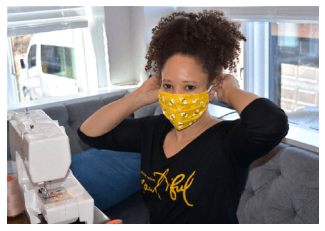

with_mask 55 %


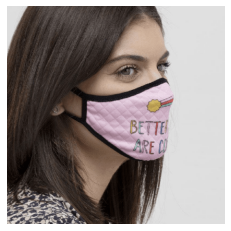

without_mask 66 %


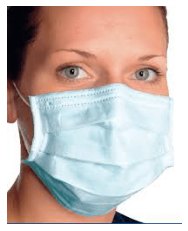

with_mask 64 %


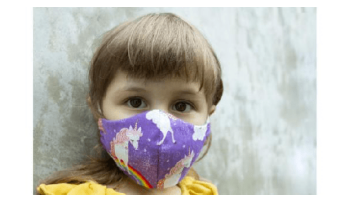

with_mask 72 %


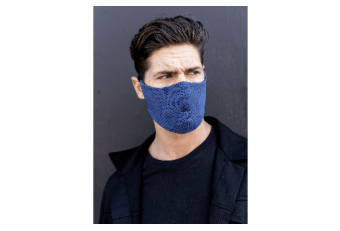

without_mask 68 %


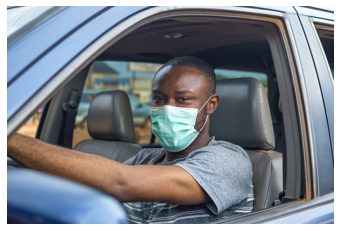

without_mask 73 %


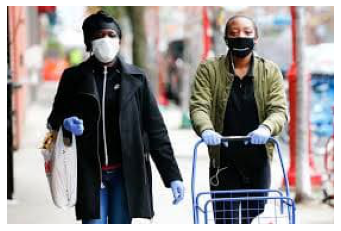

with_mask 71 %


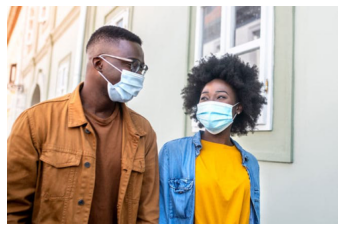

without_mask 73 %


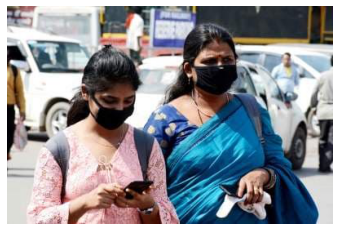

without_mask 73 %


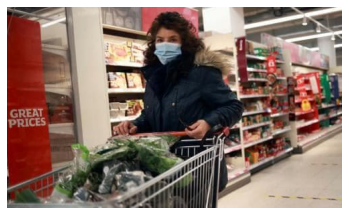

without_mask 72 %


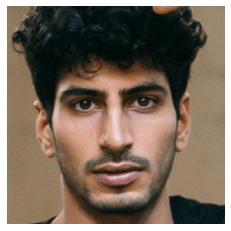

without_mask 53 %


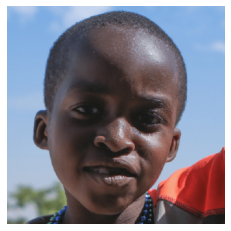

with_mask 73 %


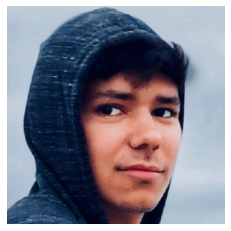

without_mask 65 %


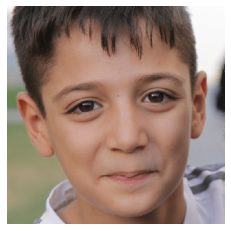

with_mask 58 %


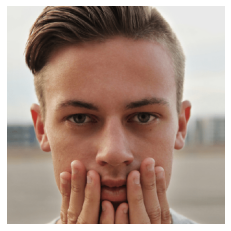

without_mask 55 %


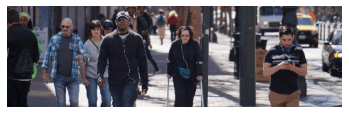

without_mask 63 %


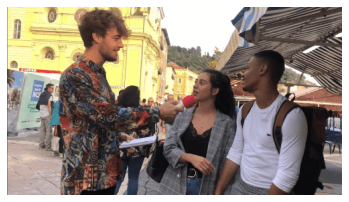

without_mask 72 %


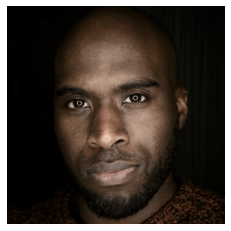

with_mask 73 %


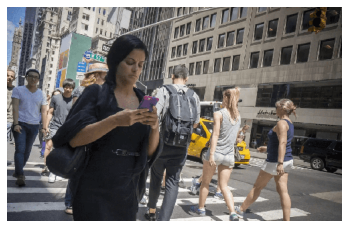

with_mask 63 %


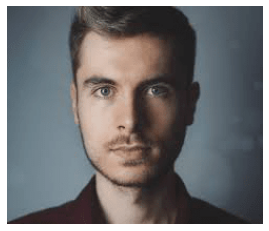

Accuracy :  0.55


In [25]:
predictions = model.predict(validation_images)
print(predictions)

accuracy = 0

for nb_image in range(len(validation_images)):
    
    fig, ax = plt.subplots()

    img = Image.open(validation_filenames[nb_image]) # On ouvre l'image avec sa taille originale
    we, he = img.size  # largeur et hauteur de l'image initiale
    ax.imshow(img) # on affiche l'image
    
    classes_predcitions = predictions[nb_image] # les prédictions des classes
    

    
    # determination de la categorie : 
    probas = tf.nn.softmax(classes_predcitions)
    pourcentage = int(round(100*np.max(probas), 0))
    category_predicted = categories[np.argmax(probas)] 

    print(category_predicted, pourcentage, "%")
    
    if (np.argmax(probas) == validation_labels[nb_image]):
        accuracy = accuracy + 1

    
    plt.axis('off')  # si on veut enlever les graduations des axes
    plt.show()
    
print("Accuracy : ", accuracy/len(validation_images) )